# Testing some different approaches in loading the data

1. Using librosa (turns out to be very slow when reading the audio, but computes spectrograms much faster)
2. Using tfio (reads audio very fast)

### Second part of the notebook:
Test different hyperparameter settings for sampling rate, nfft, nmels etc.

### Imports

In [2]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm

import tensorflow as tf
# Set logging level to avoid unnecessary messages
tf.get_logger().setLevel('ERROR')
# Set autograph verbosity to avoid unnecessary messages
tf.autograph.set_verbosity(0)

import tensorflow_io as tfio
import tensorflow_probability as tfp
import tensorflow_extra as tfe

import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

from pathlib import Path
import sys
import os
import time
import warnings
# suppress all warnings
warnings.filterwarnings("ignore")

XC_ROOTDIR = '../../data/' # directory to save data in
XC_DIR = 'test_dataset10' # subdirectory name of dataset

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Load dataset

In [6]:
df = pd.read_csv("../../data/dataset10.csv")

In [8]:
df.head()

gen      sp     ssp  group                en                     rec  \
0  Turdus  merula     NaN  birds  Common Blackbird  Beatrix Saadi-Varchmin   
1  Turdus  merula     NaN  birds  Common Blackbird        Ireneusz Oleksik   
2  Turdus  merula  merula  birds  Common Blackbird         Frank Holzapfel   
3  Turdus  merula     NaN  birds  Common Blackbird         Elias A. Ryberg   
4  Turdus  merula     NaN  birds  Common Blackbird        Nelson Conceição   

        cnt                                                loc      lat  \
0   Germany   Bad Endorf (near Rosenheim)), Oberbayern, Bayern  47.9075   
1    Poland        ROD Browarnik (near  Tychy), Tychy, śląskie  50.1329   
2   Germany                  Hochdorf / Enz, Baden-Württemberg  48.8867   
3    Norway                                    Stange, Hedmark  60.7225   
4  Portugal  Santa Maria, Mato Santo Espírito(near  Tavira)...  37.1379   

       lng  ... playback-used temp regnr auto  dvc  mic    smp nr other  \
0  12.2896  ...            no  NaN   NaN   no  NaN  NaN  44100        1   
1  18.9570  ...            no  NaN   NaN   no  NaN  NaN  48000        1   
2   8.9957  ...            no  NaN   NaN   no  NaN  NaN  48000        0   
3  11.1095  ...            no  NaN   NaN   no  NaN  NaN  48000        2   
4  -7.6303  ...            no  NaN   NaN   no  NaN  NaN  48000        0   

  length_seconds                                       fullfilename  
0            299  ../data/dataset10/Turdus merula_Common Blackbi...  
1            297  ../data/dataset10/Turdus merula_Common Blackbi...  
2            295  ../data/dataset10/Turdus merula_Common Blackbi...  
3            291  ../data/dataset10/Turdus merula_Common Blackbi...  
4            290  ../data/dataset10/Turdus merula_Common Blackbi...  

[5 rows x 40 columns]

### Configurations

In [202]:
class cfg:
    seed = 42

    # audio clip settings
    sr = 24000 # the target sampling rate
    duration = 20 # the duration of the clips
    n_samples = duration*sr
    hop_length = 2048 # "stepsize" of the fft for the melspectrograms
    nfft = 4096 # windowsize of the fft for the melspectrograms
    n_mels = 64 # number of mel frequency bins
    fmax = sr/2 # maximum frequency in the melspectrograms
    output_dim = (int(duration*sr/hop_length + 1), n_mels)

    # class labels/names
    names = list(np.unique(df.en))
    num_classes = len(names)
    labels = list(range(num_classes))
    label2name = dict(zip(labels, names))
    name2label = {v:k for k,v in label2name.items()}

tf.keras.utils.set_random_seed(cfg.seed)

## Test laoding time for different functions/libraries

In [20]:
for path in tqdm(df.fullfilename[:30]):
    audio, sr = librosa.load("../" + path, sr = cfg.sr)

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [01:54<00:00,  3.80s/it]


In [24]:
for path in tqdm(df.fullfilename[:30]):
    audio = tfio.audio.AudioIOTensor("../" + path, dtype = tf.float32)
    audio = audio.to_tensor()

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:33<00:00,  1.12s/it]


In [117]:
def loader_librosa(filepath):
    audio, sr = librosa.load(filepath, sr = cfg.sr)
     # randomly pad clip if shorter
    if len(audio) < cfg.duration*sr:
        _ = np.zeros(window*sr)
        rand_idx = np.random.randint(0, cfg.duration*sr-len(audio))
        _[rand_idx:rand_idx + len(audio)] = audio
        audio = _
    else: # select random window if clip longer
        rand_idx = np.random.randint(0, len(audio) - cfg.duration*cfg.sr)
        audio = audio[rand_idx:rand_idx + cfg.duration*cfg.sr]
    return audio

def loader_tf(filepath):
    audio = tfio.audio.AudioIOTensor(filepath, dtype = tf.float32)
    sr =  audio.rate
    length = tf.cast(audio.shape[0], tf.int32)
    # get clip
    if length/sr < cfg.duration:
        audio = audio.to_tensor()
    else:
        rdm = np.random.randint(0, length - cfg.duration*sr)
        audio = audio[rdm:rdm+cfg.duration*sr]
    audio = tf.cast(audio, tf.float32)
    # resample if necessary
    audio = tfio.audio.resample(audio, tf.cast(sr, tf.int64), cfg.sr) if sr != cfg.sr else audio
    # stereo to mono
    audio = tf.reduce_mean(audio, axis=-1) if tf.shape(audio)[-1] == 2 else tf.squeeze(audio, axis = -1)
    # pad if necessary
    if tf.size(audio) < cfg.n_samples:
        missing = cfg.n_samples - tf.size(audio)
        np.random.randint(0, missing)
        audio = tf.pad(audio, [[rdm, missing-rdm]]) # pad rdm zeros left and missing-rdm zeros rigth
    audio = tf.reshape(audio, [cfg.sr*cfg.duration])
    return audio

In [67]:
for path in tqdm(df.fullfilename[:30]):
    audio = loader_librosa("../" + path)

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [01:45<00:00,  3.52s/it]


In [118]:
for path in tqdm(df.fullfilename[:30]):
    audio = loader_tf("../" + path)

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:17<00:00,  1.76it/s]


In [69]:
audio = loader_librosa("../" + df.fullfilename[0])
Audio(data = audio, rate = cfg.sr)

In [70]:
audio = loader_tf("../" + df.fullfilename[0])
Audio(data = audio, rate = cfg.sr)

### Mel spectrogram calculation

In [119]:
audios = []
for path in tqdm(df.fullfilename[:30]):
    audios.append(loader_tf("../" + path))

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:18<00:00,  1.66it/s]


In [107]:
def melspec_librosa(audio):
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=cfg.sr, n_fft=cfg.nfft, hop_length=cfg.hop_length, n_mels=cfg.n_mels, fmax=cfg.fmax)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    return log_mel_spectrogram

def melspec_tf(audio):
    spectrogram = tfio.audio.spectrogram(audio, nfft=cfg.nfft, window=cfg.nfft, stride=cfg.hop_length)
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=cfg.sr, mels=cfg.n_mels, fmin=0, fmax=cfg.fmax)
    dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
    return dbscale_mel_spectrogram

(64, 235)


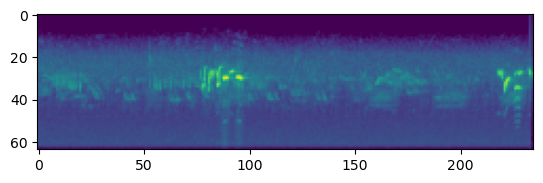

In [120]:
spec = melspec_tf(audios[0]).numpy().T
plt.figure()
plt.imshow(spec)
print(spec.shape)

(64, 235)


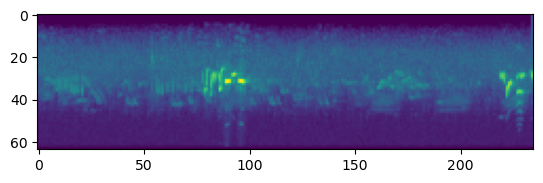

In [127]:
spec = melspec_librosa(audios[0].numpy())
plt.figure()
plt.imshow(spec)
print(spec.shape)

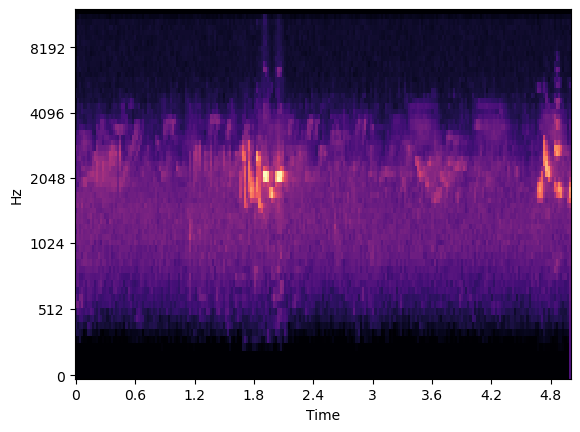

In [128]:
librosa.display.specshow(spec, sr = cfg.sr, x_axis = "time", y_axis = "mel")

In [129]:
audios_numpy = []
for audio in audios:
    audios_numpy.append(audio.numpy())

In [130]:
for audio in tqdm(audios_numpy):
    spec = melspec_librosa(audio)

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.40it/s]


In [131]:
for audio in tqdm(audios):
    spec = melspec_tf(audio)

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.05it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.89it/s]


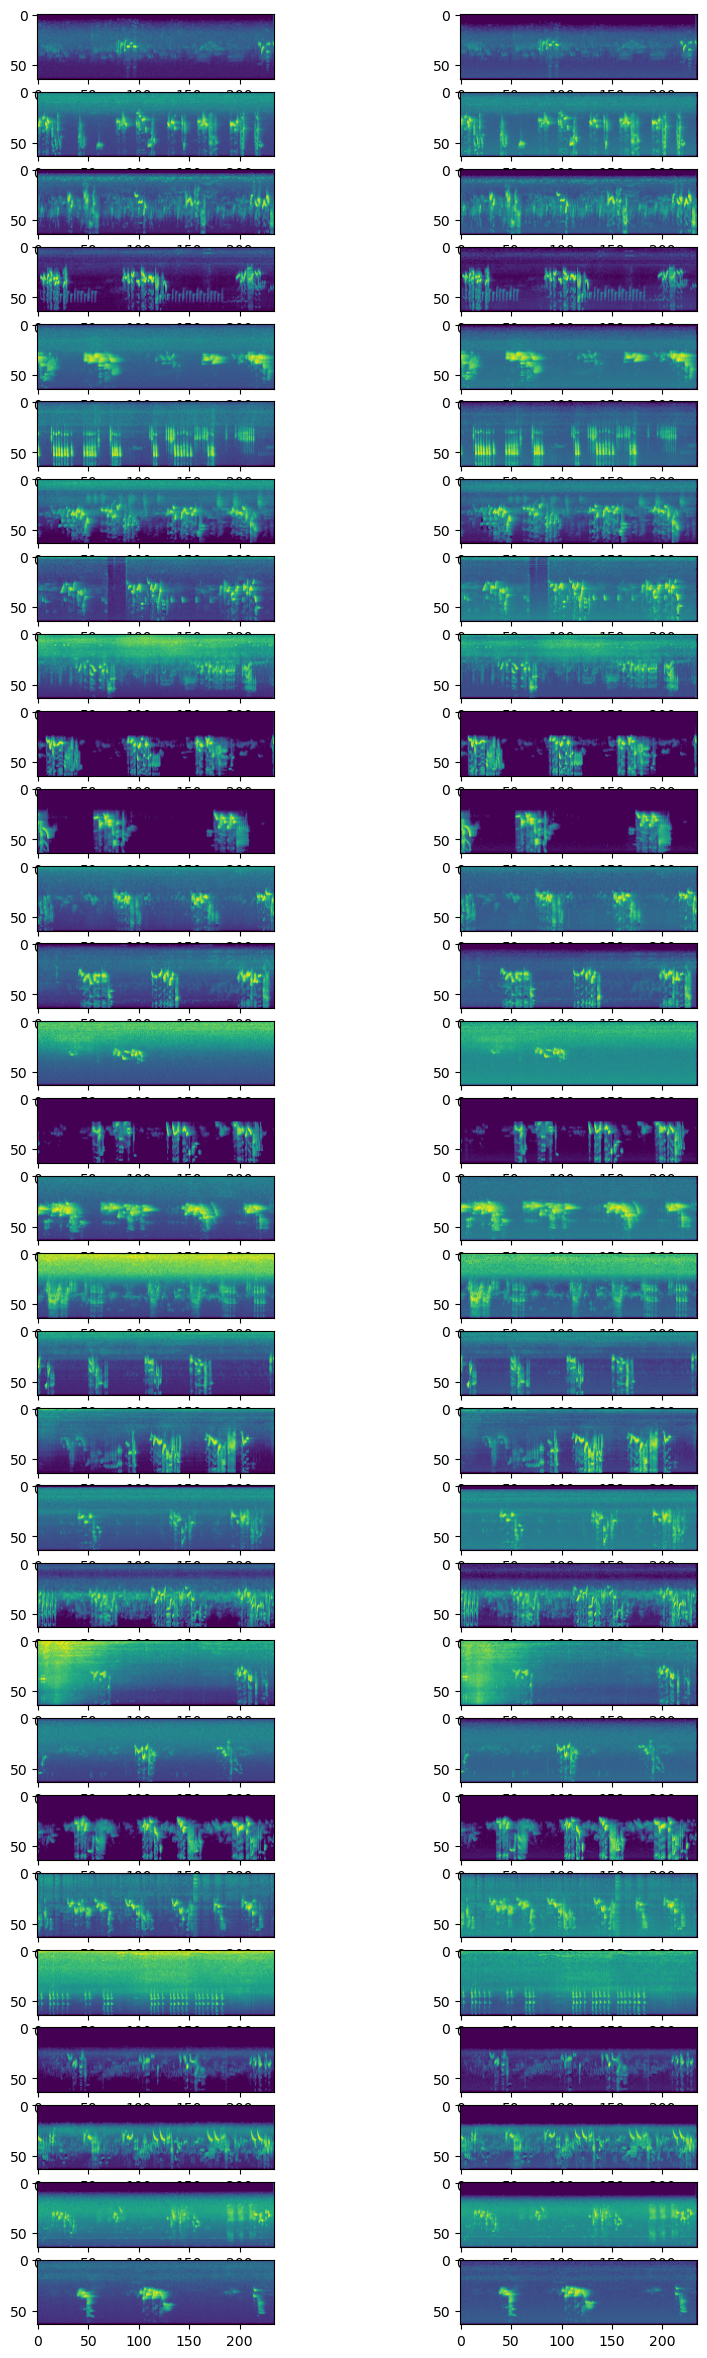

In [148]:
fig, ax = plt.subplots(nrows = int(len(audios)), ncols = 2, figsize = (10, 30))
for i in tqdm(range(len(audios_numpy))):
    spec1 = melspec_librosa(audios_numpy[i])
    spec2 = melspec_tf(audios[i])
    ax[i, 0].imshow(spec1)
    ax[i, 1].imshow(spec2.numpy().T)

### Full functions (reading audio + spectrogram)

In [158]:
def loader_librosa(filepath, sr=cfg.sr, duration=cfg.duration, nfft=cfg.nfft, hop_length=cfg.hop_length, n_mels=cfg.n_mels, fmax=cfg.fmax):
    audio, sr = librosa.load(filepath, sr = sr)
     # randomly pad clip if shorter
    if len(audio) < duration*sr:
        _ = np.zeros(duration*sr)
        rand_idx = np.random.randint(0, duration*sr-len(audio))
        _[rand_idx:rand_idx + len(audio)] = audio
        audio = _
    else: # select random window if clip longer
        rand_idx = np.random.randint(0, len(audio) - duration*sr)
        audio = audio[rand_idx:rand_idx + duration*sr]
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=nfft, hop_length=hop_length, n_mels=n_mels, fmax=fmax)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    return log_mel_spectrogram

def loader_tf(filepath, sr_target=cfg.sr, duration = cfg.duration, nfft=cfg.nfft, hop_length=cfg.hop_length, n_mels=cfg.n_mels, fmax=cfg.fmax):
    audio = tfio.audio.AudioIOTensor(filepath, dtype = tf.float32)
    sr =  audio.rate
    length = tf.cast(audio.shape[0], tf.int32)
    # get clip
    if length/sr < duration:
        audio = audio.to_tensor()
    else:
        rdm = np.random.randint(0, length - duration*sr)
        audio = audio[rdm:rdm+duration*sr]
    audio = tf.cast(audio, tf.float32)
    # resample if necessary
    audio = tfio.audio.resample(audio, tf.cast(sr, tf.int64), sr_target) if sr != sr_target else audio
    # stereo to mono
    audio = tf.reduce_mean(audio, axis=-1) if tf.shape(audio)[-1] == 2 else tf.squeeze(audio, axis = -1)
    # pad if necessary
    if tf.size(audio) < duration*sr_target:
        missing = duration*sr_target - tf.size(audio)
        np.random.randint(0, missing)
        audio = tf.pad(audio, [[rdm, missing-rdm]]) # pad rdm zeros left and missing-rdm zeros rigth
    audio = tf.reshape(audio, [sr_target*duration])
    spectrogram = tfio.audio.spectrogram(audio, nfft=nfft, window=nfft, stride=hop_length)
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sr_target, mels=n_mels, fmin=0, fmax=fmax)
    dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
    return dbscale_mel_spectrogram

In [151]:
specs1 = []
for path in tqdm(df.fullfilename[:30]):
    specs1.append(loader_librosa("../" + path))

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [01:47<00:00,  3.57s/it]


In [157]:
specs2 = []
for path in tqdm(df.fullfilename[:30]):
    specs2.append(loader_tf("../" + path))

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:18<00:00,  1.60it/s]


In [178]:
def display_specs(specs):
    fig, ax = plt.subplots(nrows = int(len(specs)), ncols = 1, figsize = (10, int(3*len(specs))))
    for i in range(len(specs)):
        if isinstance(specs[i], np.ndarray):
            ax[i].imshow(specs[i])
        else:
            ax[i].imshow(specs[i].numpy().T)

TensorShape([235, 64])

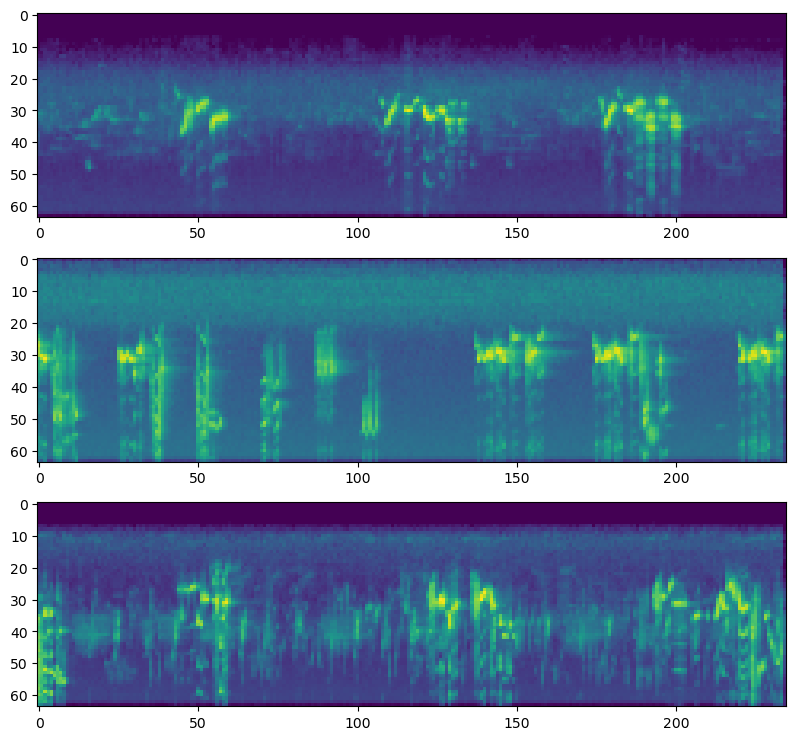

In [187]:
display_specs(specs2[:3])
specs2[0].shape

## Test different settings

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:18<00:00,  1.67it/s]


(157, 64)


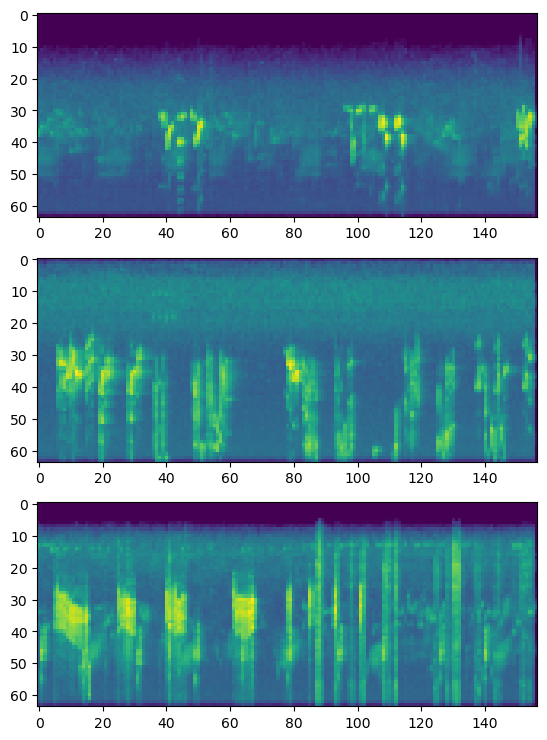

In [185]:
specs = []
for path in tqdm(df.fullfilename[:30]):
    specs.append(loader_tf("../" + path, sr_target=16000, fmax=8000))
print(specs[0].shape)
display_specs(specs[:3])

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:19<00:00,  1.53it/s]


(625, 128)


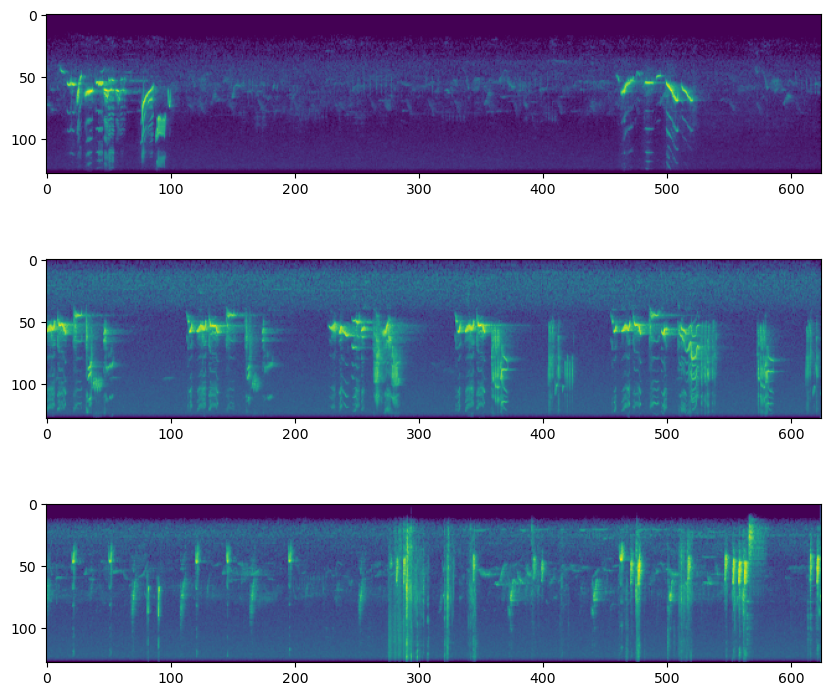

In [203]:
specs = []
for path in tqdm(df.fullfilename[:30]):
    specs.append(loader_tf("../" + path, 
                           sr_target=32000, duration = 20, nfft=2048, hop_length=1024, n_mels=128, fmax=16000))
print(specs[0].shape)
display_specs(specs[:3])

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:19<00:00,  1.54it/s]


(625, 64)


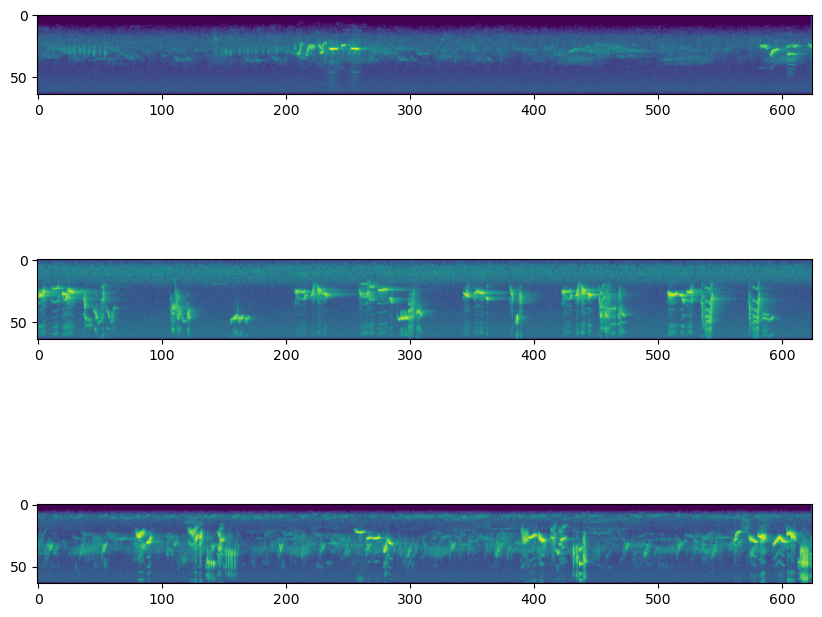

In [204]:
specs = []
for path in tqdm(df.fullfilename[:30]):
    specs.append(loader_tf("../" + path, 
                           sr_target=32000, duration = 20, nfft=2048, hop_length=1024, n_mels=64, fmax=16000))
print(specs[0].shape)
display_specs(specs[:3])

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:18<00:00,  1.60it/s]


(469, 128)


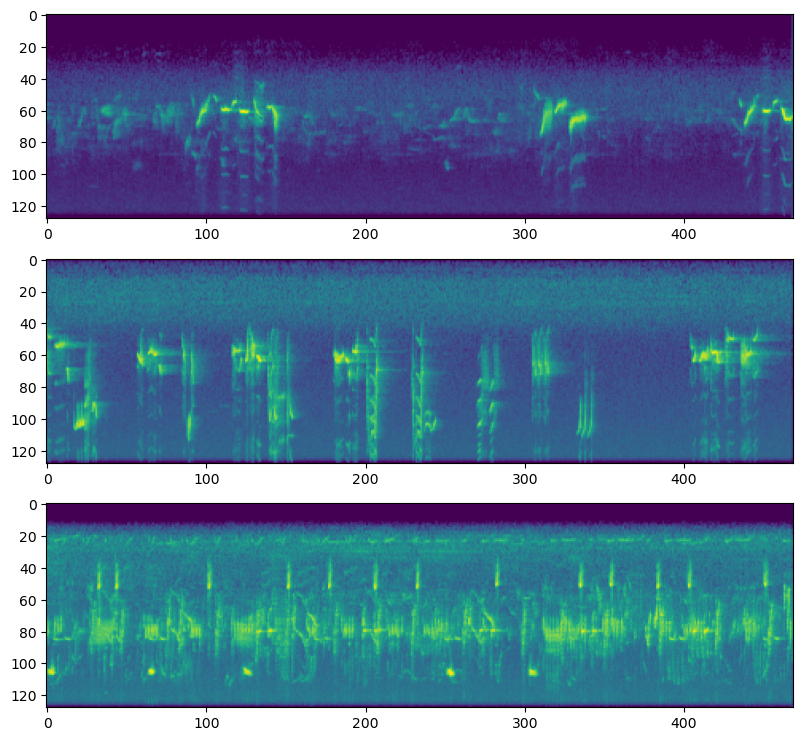

In [205]:
specs = []
for path in tqdm(df.fullfilename[:30]):
    specs.append(loader_tf("../" + path, 
                           sr_target=24000, duration = 20, nfft=2048, hop_length=1024, n_mels=128, fmax=12000))
print(specs[0].shape)
display_specs(specs[:3])

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:19<00:00,  1.56it/s]


(469, 64)


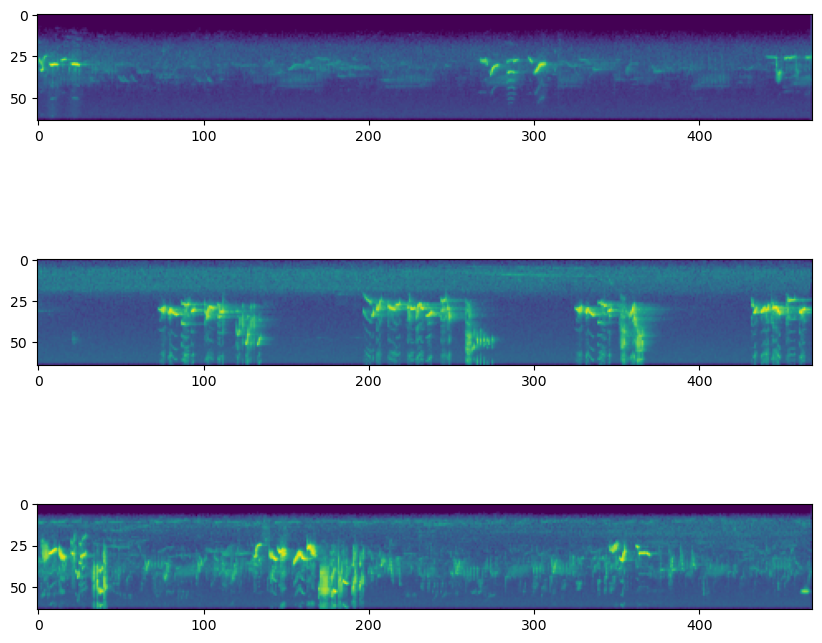

In [209]:
specs = []
for path in tqdm(df.fullfilename[:30]):
    specs.append(loader_tf("../" + path, 
                           sr_target=24000, duration = 20, nfft=2048, hop_length=1024, n_mels=64, fmax=12000))
print(specs[0].shape)
display_specs(specs[:3])

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:18<00:00,  1.61it/s]


(313, 128)


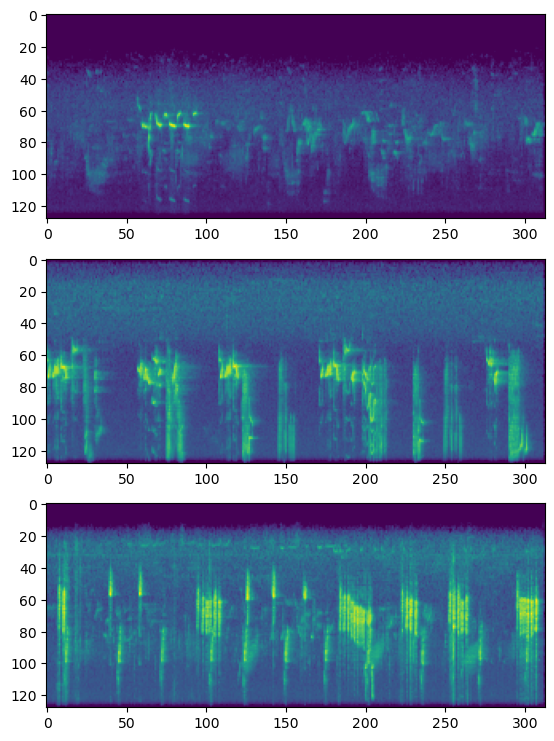

In [206]:
specs = []
for path in tqdm(df.fullfilename[:30]):
    specs.append(loader_tf("../" + path, 
                           sr_target=16000, duration = 20, nfft=2048, hop_length=1024, n_mels=128, fmax=8000))
print(specs[0].shape)
display_specs(specs[:3])

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:19<00:00,  1.57it/s]


(235, 128)


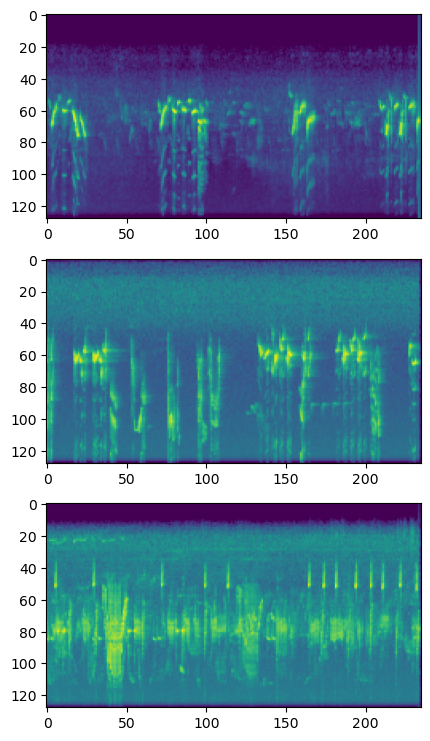

In [208]:
specs = []
for path in tqdm(df.fullfilename[:30]):
    specs.append(loader_tf("../" + path, 
                           sr_target=24000, duration = 20, nfft=4096, hop_length=2048, n_mels=128, fmax=12000))
print(specs[0].shape)
display_specs(specs[:3])

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:18<00:00,  1.60it/s]


(938, 128)


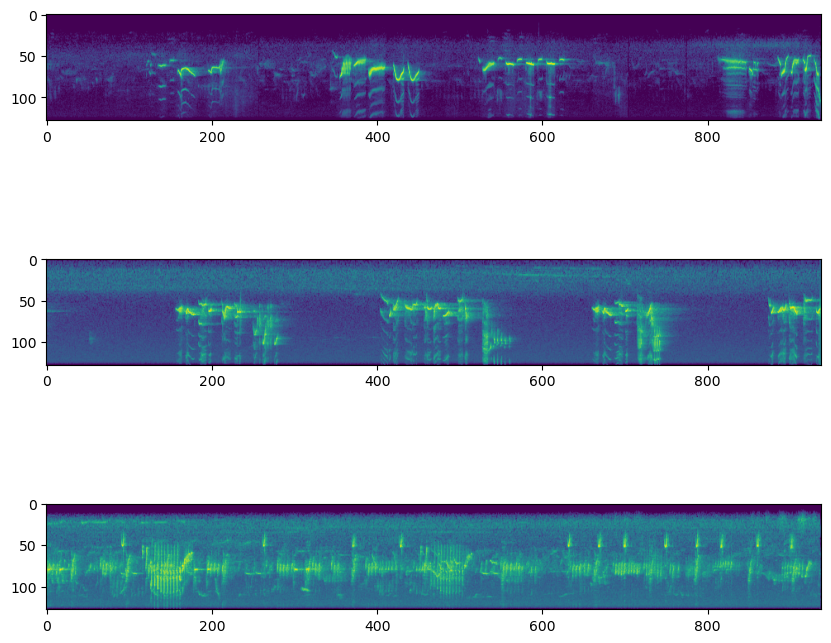

In [207]:
specs = []
for path in tqdm(df.fullfilename[:30]):
    specs.append(loader_tf("../" + path, 
                           sr_target=24000, duration = 20, nfft=1024, hop_length=512, n_mels=128, fmax=12000))
print(specs[0].shape)
display_specs(specs[:3])

### Cost of longer duration

In [216]:
for path in tqdm(df.fullfilename[:30]):
    spec = loader_tf("../" + path, duration = 5, n_mels=128)

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.67it/s]


In [211]:
for path in tqdm(df.fullfilename[:30]):
    spec = loader_tf("../" + path, duration = 10, n_mels=128)

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.48it/s]


In [213]:
for path in tqdm(df.fullfilename[:30]):
    spec = loader_tf("../" + path, duration = 20, n_mels=128)

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:18<00:00,  1.60it/s]


In [214]:
for path in tqdm(df.fullfilename[:30]):
    spec = loader_tf("../" + path, duration = 30, n_mels=128)

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:25<00:00,  1.15it/s]


In [215]:
for path in tqdm(df.fullfilename[:30]):
    spec = loader_tf("../" + path, duration = 40, n_mels=128)

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:33<00:00,  1.10s/it]
